In [6]:
import sys
from copy import deepcopy
import numpy as np
from astropy.table import Table
import matplotlib.pyplot as plt
import copy
from astropy.io import ascii
import plot_util
import sncosmo
import scipy
import corner,pickle
from scipy.stats import rv_continuous,gaussian_kde,norm as normal
import astropy.cosmology as cosmo
import matplotlib.gridspec as gridspec
sys.path.append('/Users/jpierel/CodeBase/sntd')
import sntd

In [7]:
data=ascii.read('snRequiem.dat')
t_obs = 57588
data['time']= 0
data['flux']=data['psf_flux']
models=ascii.read('lens_models.dat')
data['mag']=-2.5*np.log10(data['flux'])+data['zp']
data['magerr']=1.0857*data['fluxerr']/data['flux']
im0=data[data['id']==0]
im1=data[data['id']==1]
im2=data[data['id']==2]
models=models[models['MODEL']!='SN.4']
zp=23.9
cosmology=cosmo.FlatLambdaCDM(Om0=.3,H0=70)
#cosmology=cosmo.FlatLambdaCDM(Om0=.3,H0=74)

In [8]:
class skewed_normal(rv_continuous):
    "Skewed Normal Distribution"
    def _pdf(self,x,mu,left_sigma,right_sigma):
        try:
            mu=list(mu)[0]
            left_sigma=list(left_sigma)[0]
            right_sigma=list(right_sigma)[0]
        except:
            pass

        left=normal(loc=mu,scale=left_sigma)
        right=normal(loc=mu,scale=right_sigma)
        pdf=np.piecewise(x,[x<mu,x>=mu],
                         [lambda y : scipy.stats.norm.pdf(
                            y, 
                            loc = mu, 
                            scale = left_sigma)/np.max(left.pdf(y)),
                          lambda y : scipy.stats.norm.pdf(
                                    y, 
                                    loc = mu, 
                                    scale = right_sigma)/np.max(right.pdf(y))])
        return(pdf/scipy.integrate.simps(pdf,x))

def _param_from_dist(dist):
    a=np.min(dist)-abs(np.min(dist))
    b=np.max(dist)+abs(np.max(dist))
    pdf=gaussian_kde(dist.T)#.pdf(np.arange(a,b,.001))
    return(pdf)#/scipy.integrate.simps(pdf))
def bounds_to_ppf(bounds):
    ppfs={}
    for key in bounds.keys():
        a,b=bounds[key]
        f = sncosmo.utils.Interp1D(0., 1., np.array([a, b]))
        ppfs[key]=f
    return ppfs

def prior_transform(nested_parameters):
        actual_parameters = np.empty(n_varied_parameter_dim, dtype=np.float)
        for i in range(n_varied_parameter_dim):
            actual_parameters[i] = ppfs[varied_param_names[i]](nested_parameters[i])
        return actual_parameters
class posterior(rv_continuous):
    "Skewed Normal Distribution"
    def _pdf(self,x,samples,weights):
        pdf,edges=np.histogram(samples,weights=weights,
                               bins=20,density=True)
        func=scipy.interpolate.interp1d([(edges[i]+edges[i+1])/2 for i in range(len(edges)-1)],
                                       pdf,fill_value=0,bounds_error=False)
        return(func(x))

    def _argcheck(self,*args):
        return True

def nice_corner(sample_result,labs=["Age Image 1","Age Image 2","Age Image 3", "c","$M_B$"]
                ,color='k'):
    fig = corner.corner(
            sample_result.samples,
            weights=sample_result.weights,
            labels=labs,
            quantiles=(0.16,.5, 0.84),
            bins = 30,\
           color=color,\
           show_titles=True,\
           title_fmt = '.2f',\
           smooth1d=False,\
           smooth=True,\
           fill_contours=True,\
           plot_contours =True,\
           plot_density=True,\
           use_mathtext=True,
           title_kwargs={"fontsize": 11},
           label_kwargs={'fontsize':16})
    for ax in fig.get_axes():
        ax.tick_params(axis='both',labelsize=14)
    return(fig,ax)

def calc_ev(res,nlive):
    logZnestle = res.logz                         # value of logZ
    infogainnestle = res.h                        # value of the information gain in nats
    logZerrnestle = np.sqrt(infogainnestle/nlive) # estimate of the statistcal uncertainty on logZ

    # output marginal likelihood
    print('Marginalised evidence is {} ± {}'.format(logZnestle, logZerrnestle))
    
def weighted_quantile(values, quantiles, sample_weight=None, 
                      values_sorted=False, old_style=False):
    """ Very close to numpy.percentile, but supports weights.
    NOTE: quantiles should be in [0, 1]!
    :param values: numpy.array with data
    :param quantiles: array-like with many quantiles needed
    :param sample_weight: array-like of the same length as `array`
    :param values_sorted: bool, if True, then will avoid sorting of
        initial array
    :param old_style: if True, will correct output to be consistent
        with numpy.percentile.
    :return: numpy.array with computed quantiles.
    """
    values = np.array(values)
    quantiles = np.array(quantiles)
    if sample_weight is None:
        sample_weight = np.ones(len(values))
    sample_weight = np.array(sample_weight)
    assert np.all(quantiles >= 0) and np.all(quantiles <= 1), \
        'quantiles should be in [0, 1]'

    if not values_sorted:
        sorter = np.argsort(values)
        values = values[sorter]
        sample_weight = sample_weight[sorter]

    weighted_quantiles = np.cumsum(sample_weight) - 0.5 * sample_weight
    if old_style:
        # To be convenient with numpy.percentile
        weighted_quantiles -= weighted_quantiles[0]
        weighted_quantiles /= weighted_quantiles[-1]
    else:
        weighted_quantiles /= np.sum(sample_weight)
    return np.interp(quantiles, weighted_quantiles, values)


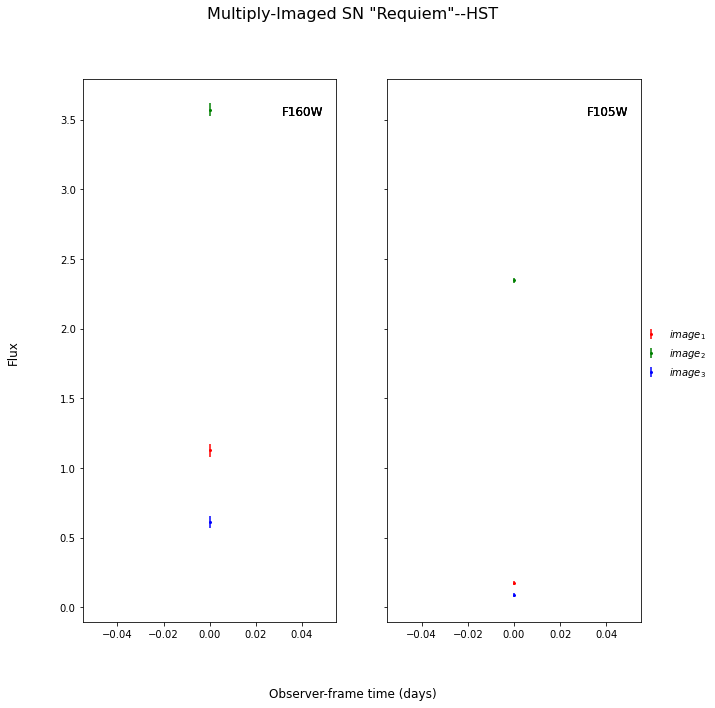

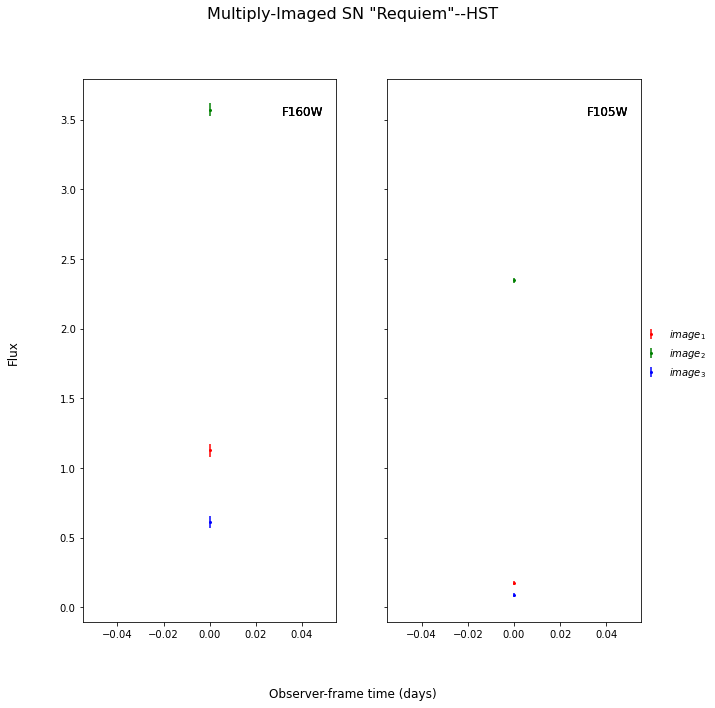

In [9]:
requiem=sntd.table_factory([im0,im1,im2],telescopename='HST',object_name='Requiem')
requiem.plot_object()

57588


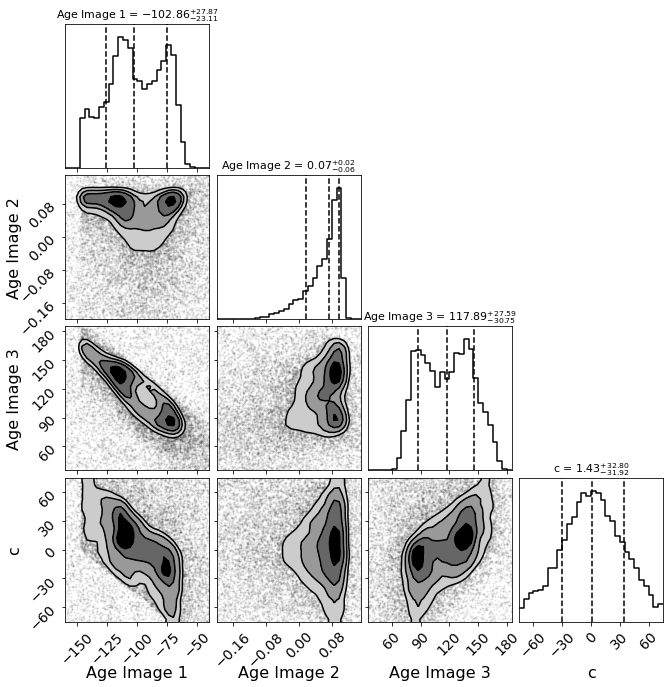

In [69]:
refit=True
if refit:
    ###SNTD COLOR FIT
    dust = sncosmo.CCM89Dust()
    model=sncosmo.Model('salt2-extended',effects=[dust],
                           effect_names=['mw'],
                           effect_frames=['obs'])
    model.set(**{'z':1.9459,'mwebv':.014,'t0':t_obs,'x1':0})

    #t0,t1,t2 are age of image id=0,1,2
    varied_param_names = ['t0','t1','t2','c']
    parameter_bounds={'c':(-.2,.2),'t2':(40,150),
                      't1':(-40,100),'t0':(40,150),'Mb':(-18,-22)}


    print(t_obs)

    n_live_points=2000
    fitCurves=sntd.fit_data(requiem,snType='Ia', models=model,bands=['F105W','F160W'],
                        params=['t0','c'],constants={'z':1.9459,'x1':0,'mwebv':.014},
                        bounds={'t0':(-60,60),'td':(-75,75),'c':(-.2,.15)},
                        method='color',modelcov=False,npoints=n_live_points,maxiter=None,
                            min_points_per_band=1,trial_fit=False,minsnr=0,use_MLE=False,
                           t0_guess={'image_1':-100,'image_2':10,'image_3':-100})
    color_res=deepcopy(fitCurves.color.fits.res)
#     for i in range(color_res.samples.shape[0]):
#         tempc=deepcopy(color_res.samples[i,1])
#         color_res.samples[i,1]=-1*deepcopy(color_res.samples[i,0])
#         color_res.samples[i,0]=deepcopy(tempc)
#         color_res.samples[i,2]=color_res.samples[i,1]-color_res.samples[i,2]
#         color_res.samples[i,3]=color_res.samples[i,1]-color_res.samples[i,3]
    nice_corner(color_res)
    plt.show()
    pickle.dump(color_res,open('colorcurve_constraint_sntd.pkl','wb'))
    
else:
    color_res=pickle.load(open('colorcurve_constraint_sntd.pkl','rb'))


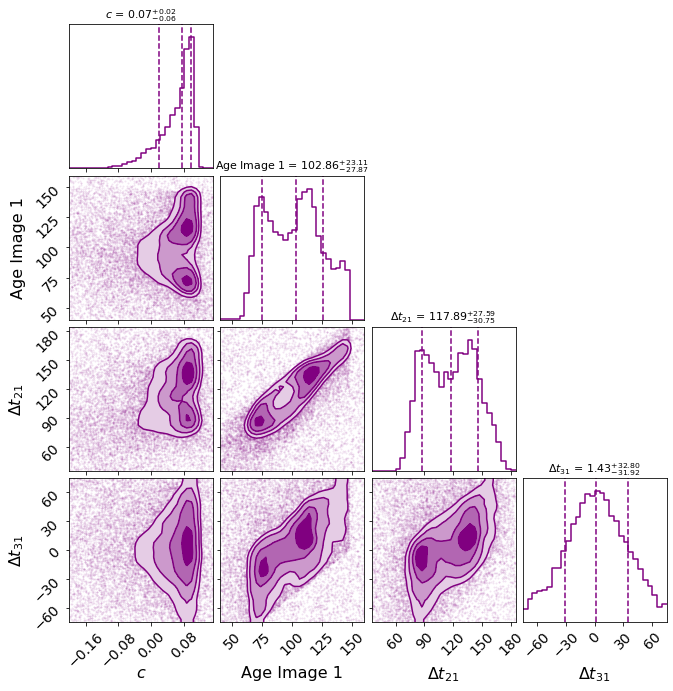

In [70]:
# Create corner
for i in range(color_res.samples.shape[0]):
    tempc=deepcopy(color_res.samples[i,1])
    color_res.samples[i,1]=-1*deepcopy(color_res.samples[i,0])
    color_res.samples[i,0]=deepcopy(tempc)
nice_corner(color_res,
            labs=['$c$','Age Image 1','$\Delta t_{21}$','$\Delta t_{31}$'],color='purple')
plt.savefig('corner_color_curve_fit_sntd.pdf',format='pdf')
plt.show()

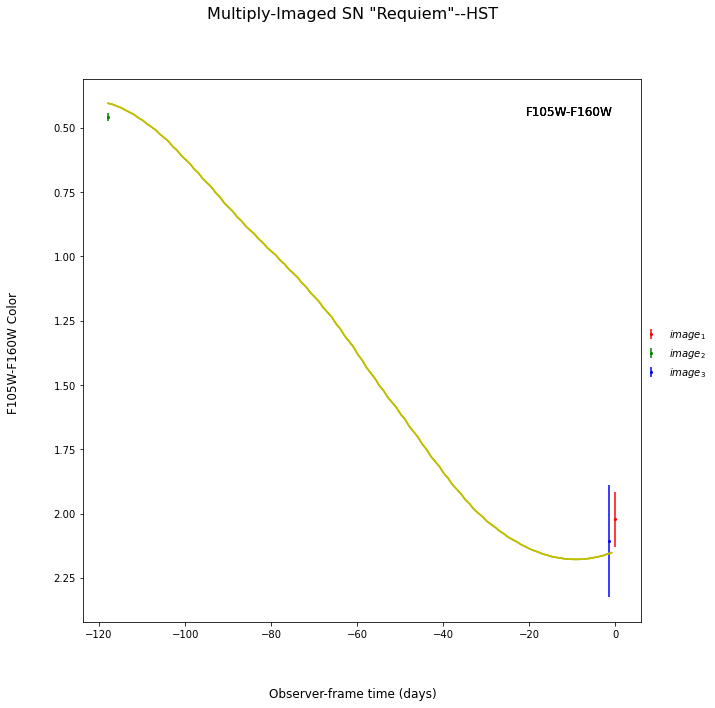

In [71]:
##PLOT MLE, not 50th percentile##
requiem.plot_object(showFit=True,method='color')
plt.show()

In [14]:
lens_models_to_fit = ['H']
corrected_data = deepcopy(data)
print(corrected_data['flux'])
for lens_model in lens_models_to_fit:
    temp_lens=models[models['MODEL']==lens_model]
    for b in ['F105W','F160W']:
        b_inds=np.where(corrected_data['band']==b.lower())[0]
        print(b_inds)
        temp_flux=[]
        temp_fluxerr=[]
        for im in [im0,im1,im2]:
            mu=temp_lens['MU'][temp_lens['image']=='SN.'+str(im['id'][0]+1)]
            muerr=temp_lens['ERR_MU'][temp_lens['image']=='SN.'+str(im['id'][0]+1)]
            b_ind=np.where(im['band']==b.lower())[0][0]
            flux_err2=(im['flux'][b_ind]/mu)*np.sqrt((im['fluxerr'][b_ind]/im['flux'][b_ind])**2+\
                                               (muerr/mu)**2)
            
            temp_flux=np.append(temp_flux,im['flux'][b_ind]/mu)
            temp_fluxerr=np.append(temp_fluxerr,flux_err2)
        for i in range(len(b_inds)):
            corrected_data[b_inds[i]]['flux']=temp_flux[i]
            corrected_data[b_inds[i]]['fluxerr']=temp_fluxerr[i]
corrected_data=corrected_data[corrected_data['band']=='f160w']
im0_corr=corrected_data[corrected_data['id']==0]
im1_corr=corrected_data[corrected_data['id']==1]
im2_corr=corrected_data[corrected_data['id']==2]
requiem_corrected=sntd.table_factory([im0_corr,im1_corr,im2_corr],telescopename='HST',object_name='Requiem')


 flux 
------
0.1748
2.3471
0.0877
1.1265
3.5715
0.6113
[0 1 2]
[3 4 5]


In [72]:
refit=True
if refit:
    cosmology = cosmo.FlatLambdaCDM(name="WMAP9", H0=70, Om0=0.3)
    dust = sncosmo.CCM89Dust()
    model=sncosmo.Model('salt2-extended',effects=[dust],
                           effect_names=['mw'],
                           effect_frames=['obs'])
    model.set(**{'z':1.9459,'mwebv':.014,'t0':0,'x1':0})
    model.set_source_peakabsmag(-17,'bessellb','ab',cosmo=cosmology)
    minx0=model.get('x0')
    model.set_source_peakabsmag(-22,'bessellb','ab',cosmo=cosmology)
    maxx0=model.get('x0')

    lens_models_to_fit=['H']
    #t0,t1,t2 are age of image id=0,1,2
    varied_param_names = ['t0','t1','t2','c','Mb']
    modelcov=True
    #full range bounds first, then tightened
    #parameter_bounds={'c':(-.3,.5),'t0':(-45,time[-1]),
    #                  't1':(-45,time[-1]),'t2':(-45,time[-1]),'Mb':(-17,-20.8)}
    parameter_bounds={'c':(-.2,.2),'t2':(40,150),
                      't1':(-40,100),'t0':(40,150),'Mb':(-18,-22)}


    n_varied_parameter_dim = len(varied_param_names) 
    n_live_points=2000
    fitCurves_series=sntd.fit_data(requiem_corrected,snType='Ia', models=model,bands=['f160w'],
            params=['x0','t0','c'],constants={'z':1.9459,'x1':0,'mwebv':.014,'mu':1},refImage='image_1',
            minsnr=0,trial_fit=False,
            min_points_per_band=1,t0_guess={'image_1':-100,'image_2':10,'image_3':-100},use_MLE=True,
            bounds={'x0':(minx0,maxx0),'t0':(-100,100),'td':(-150,150),'c':(-.15,.2)},
            method='series',npoints=n_live_points)
    pickle.dump(fitCurves_series.series.fits.res,open('lc_model%s_constraint_sntd.pkl'%lens_model,'wb'))
    series_res = deepcopy(fitCurves_series.series.fits.res)
else:
    series_res = pickle.load(open('lc_model%s_constraint_sntd.pkl'%lens_model,'rb'))

['x0', 't0', 'c', 'dt_2', 'dt_3']


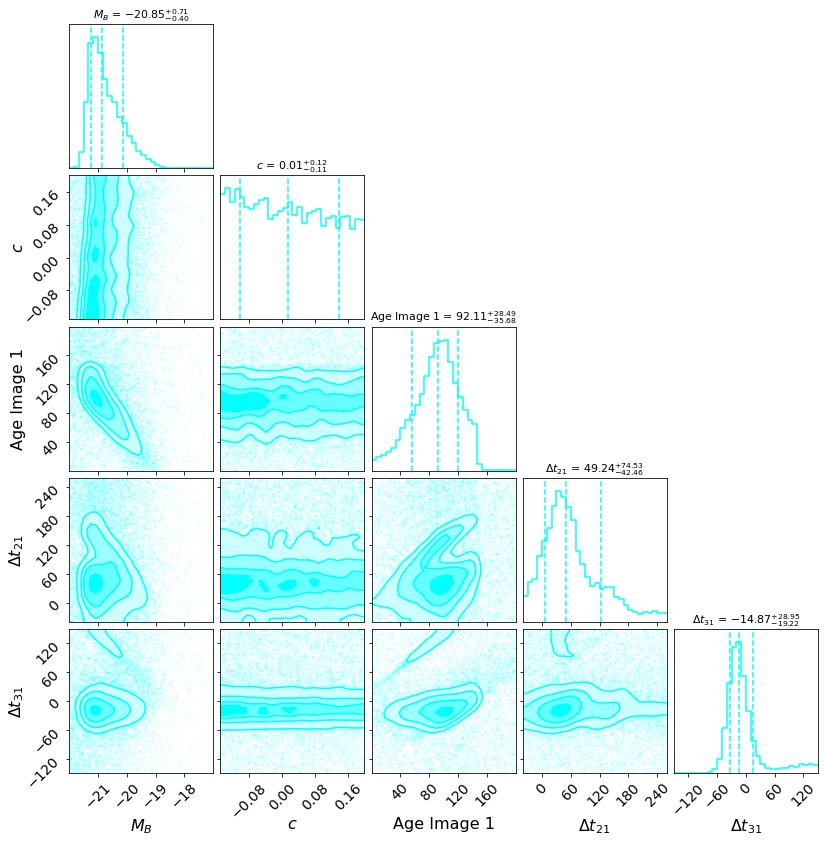

In [73]:
print(series_res.vparam_names)
temp_mod=sncosmo.Model('salt2-extended')
temp_mod.set(z=1.9459)
for i in range(series_res.samples.shape[0]):
    temp_mod.set(x0=series_res.samples[i,0])
    series_res.samples[i,0]=temp_mod.source_peakabsmag('bessellb','ab',cosmo=cosmology)
    tempc=deepcopy(series_res.samples[i,2])
    series_res.samples[i,2]=-1*deepcopy(series_res.samples[i,1])
    series_res.samples[i,1]=deepcopy(tempc)
nice_corner(series_res,
            labs=['$M_B$','$c$','Age Image 1','$\Delta t_{21}$','$\Delta t_{31}$'],color='cyan')
plt.savefig('corner_lightcurve_fit_sntd.pdf',format='pdf')
plt.show()

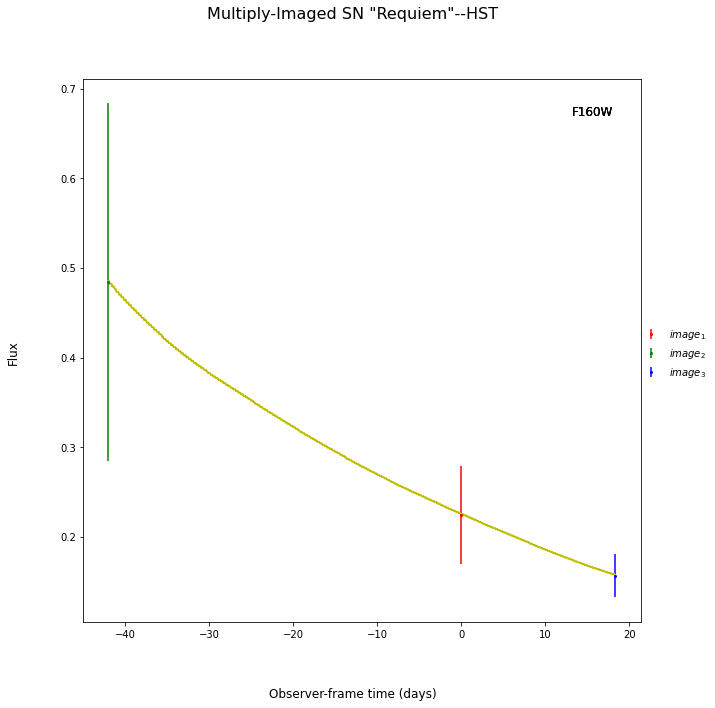

In [254]:
##PLOT WITH MLE NOT 50th PERCENTILE
fitCurves_series.plot_object(showFit=True,method='series',bands=['f160w'])
plt.show()

In [74]:
####COMBINE SERIES AND COLOR###
interp=scipy.interpolate.griddata(color_res.samples,color_res.weights,
                                series_res.samples[:,1:],
                                 fill_value=0)


In [75]:
new_res=deepcopy(series_res)
comb=interp*new_res.weights
good =np.where(np.isfinite(comb))[0]
comb=comb[good]
print(comb)
comb/=np.sum(comb)
new_res.samples=new_res.samples[good,:]
new_res.weights=comb
print(len(new_res.weights),comb)

[0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.06628663e-50
 0.00000000e+00 4.56223729e-56]
15513 [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.85318869e-45
 0.00000000e+00 7.92909366e-51]


[-2.11737974e+01  5.92293583e-02  1.03041574e+02  1.34035746e+02
 -2.98711839e+01]


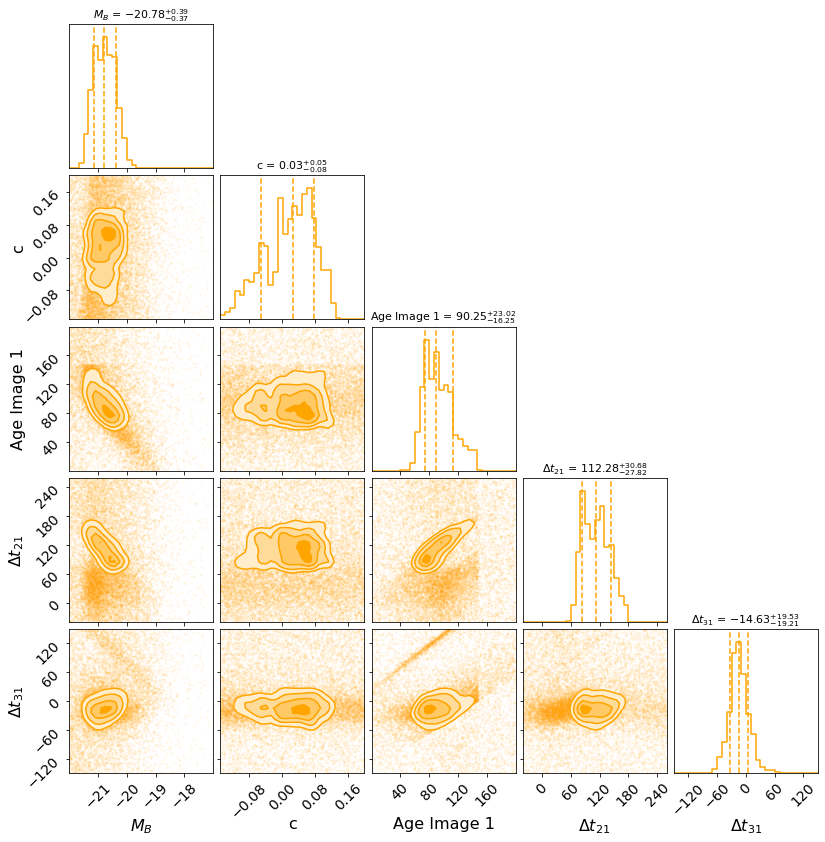

In [76]:
print(new_res.samples[new_res.weights.argmax(),:])
nice_corner(new_res,
            labs=['$M_B$','c','Age Image 1','$\Delta t_{21}$','$\Delta t_{31}$'],
           color='orange')
plt.savefig('corner_combined_fit_sntd.pdf',format='pdf')

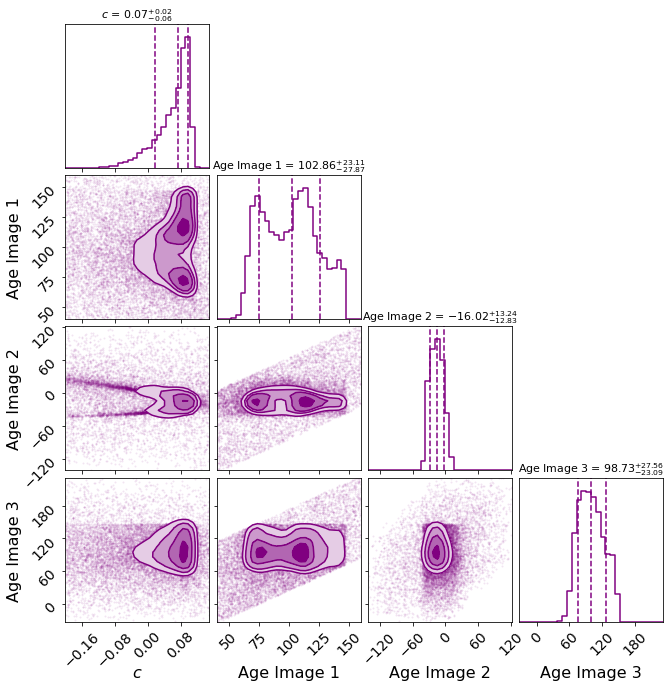

In [77]:
# Change to ages
color_res=pickle.load(open('colorcurve_constraint_sntd.pkl','rb'))
for i in range(color_res.samples.shape[0]):
    tempc=deepcopy(color_res.samples[i,1])
    color_res.samples[i,1]=-1*deepcopy(color_res.samples[i,0])
    color_res.samples[i,0]=deepcopy(tempc)
    color_res.samples[i,2]=color_res.samples[i,1]-color_res.samples[i,2]
    #color_res.samples[i,2]-=101.5
    color_res.samples[i,3]=color_res.samples[i,1]-color_res.samples[i,3]
nice_corner(color_res,
            labs=['$c$','Age Image 1','Age Image 2','Age Image 3'],color='purple')
plt.show()

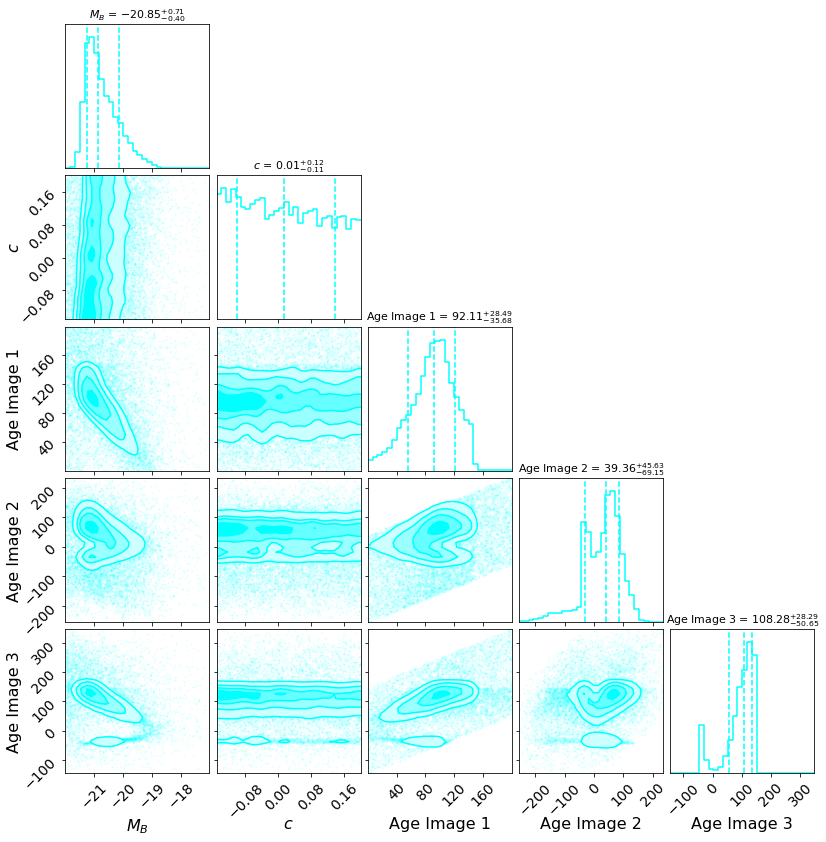

In [78]:
series_res = pickle.load(open('lc_model%s_constraint_sntd.pkl'%lens_model,'rb'))
temp_mod=sncosmo.Model('salt2-extended')
temp_mod.set(z=1.9459)
for i in range(series_res.samples.shape[0]):
    temp_mod.set(x0=series_res.samples[i,0])
    series_res.samples[i,0]=temp_mod.source_peakabsmag('bessellb','ab',cosmo=cosmology)
    tempc=deepcopy(series_res.samples[i,2])
    series_res.samples[i,2]=-1*deepcopy(series_res.samples[i,1])
    series_res.samples[i,1]=deepcopy(tempc)
    series_res.samples[i,3]=series_res.samples[i,2]-series_res.samples[i,3]
    series_res.samples[i,4]=series_res.samples[i,2]-series_res.samples[i,4]
nice_corner(series_res,
            labs=['$M_B$','$c$','Age Image 1','Age Image 2','Age Image 3'],color='cyan')
plt.show()

In [79]:
####COMBINE SERIES AND COLOR###
print(np.sum(color_res.weights),np.sum(series_res.weights))
interp=scipy.interpolate.griddata(color_res.samples,color_res.weights,
                                series_res.samples[:,1:],
                                 fill_value=0)
new_res=deepcopy(series_res)
comb=interp*new_res.weights
good =np.where(np.isfinite(comb))[0]
comb=comb[good]
comb/=np.sum(comb)
new_res.samples=new_res.samples[good,:]
new_res.weights=comb

1.0000000000000164 0.9999999999999977


[-20.44190922   0.10521317  70.38195935 -18.52098073  90.75194673]


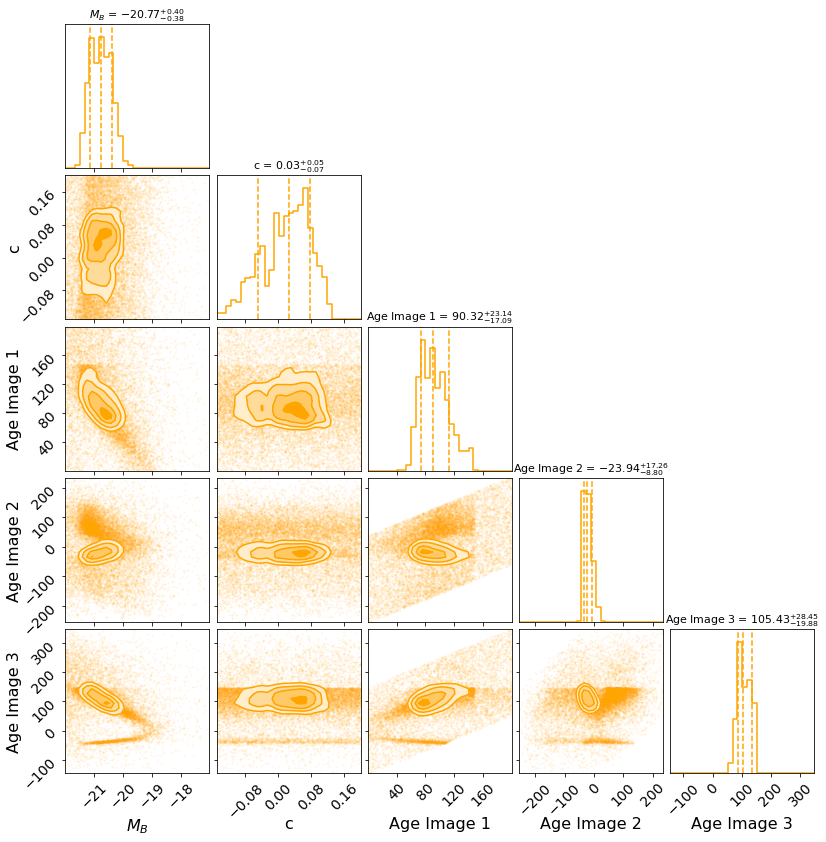

In [80]:
print(new_res.samples[new_res.weights.argmax(),:])
nice_corner(new_res,
            labs=['$M_B$','c','Age Image 1','Age Image 2','Age Image 3'],
           color='orange')
plt.show()

In [81]:
pickle.dump(new_res,open('lc_model%s_color_constraint_sntd.pkl'%lens_model,'wb'))

In [82]:
legend_fontsize=24
axis_fontsize=30
ticksize=26

0.0737140038239567 102.85893502455828 -16.023338616063246 98.72762531521175


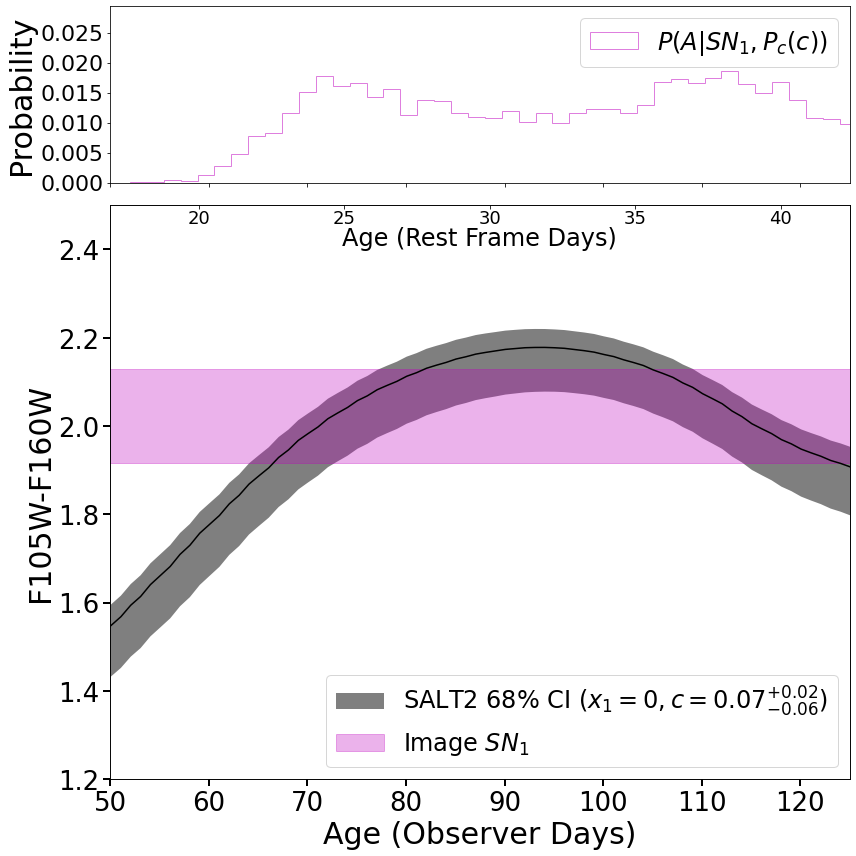

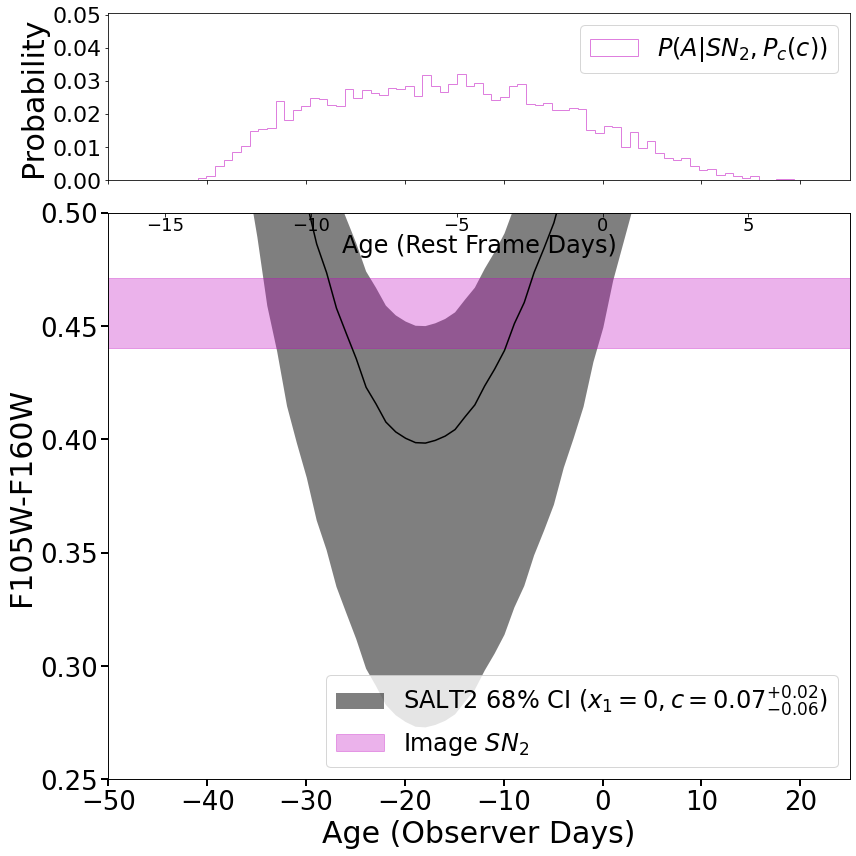

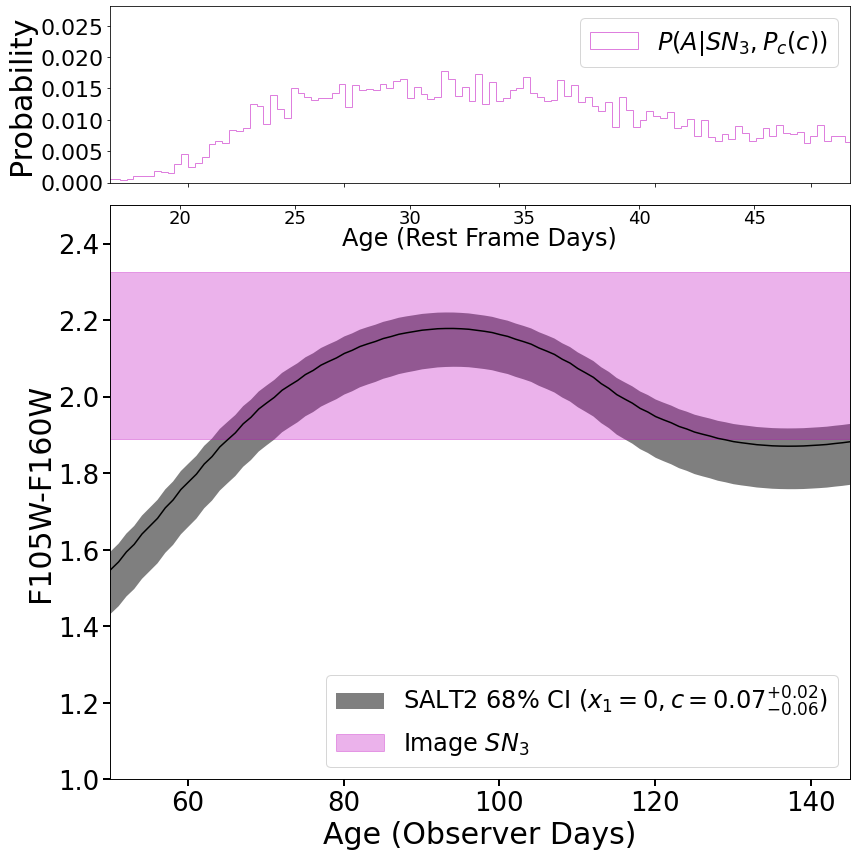

In [83]:
#make color curve fitting plots
dust = sncosmo.CCM89Dust()
model=sncosmo.Model('salt2-extended',effects=[dust],
                       effect_names=['mw'],
                       effect_frames=['obs'])
model.set(**{'z':1.9459,'mwebv':.014,'t0':0,'x1':0})

cnest_prior=pickle.load(open('colorcurve_constraint_sntd.pkl','rb'))

for i in range(cnest_prior.samples.shape[0]):
    tempc=deepcopy(cnest_prior.samples[i,1])
    cnest_prior.samples[i,1]=-1*deepcopy(cnest_prior.samples[i,0])
    cnest_prior.samples[i,0]=deepcopy(tempc)
    cnest_prior.samples[i,2]=cnest_prior.samples[i,1]-cnest_prior.samples[i,2]
    cnest_prior.samples[i,3]=cnest_prior.samples[i,1]-cnest_prior.samples[i,3]
    #cnest_prior.samples[i,2]-=124.5

ylim_dict={2:(1,2.5),1:(.25,.5),0:(1.2,2.5)}
xlim_dict={2:(50,145),1:(-50,25),0:(50,125)}

c,t0, t1,t2 = [weighted_quantile(cnest_prior.samples[:,i], .5, 
                                     sample_weight=cnest_prior.weights)\
                   for i in range(4)]

c_16,t0_16, t1_16,t2_16 = [weighted_quantile(cnest_prior.samples[:,i], .16, 
                                     sample_weight=cnest_prior.weights)\
                   for i in range(4)]
c_84,t0_84, t1_84,t2_84 = [weighted_quantile(cnest_prior.samples[:,i], .84, 
                                     sample_weight=cnest_prior.weights)\
                   for i in range(4)]
print(c,t0,t1,t2)
nbin_dict={0:70,1:300,2:300}
i=-1
for im in [im0,im1,im2]:
    i+=1     

    plot_time=np.arange(model.mintime()-10,model.maxtime()+10,1)
    model.set(c=c)
    fig=plt.figure(figsize=(12,12))
    gs = gridspec.GridSpec(4, 4)
    #fig,gs=plot_util.grid_plot(4,4)
    ax_main=fig.add_subplot(gs[1:,:])
    
    ax_main=plot_util.plot('plot',plot_time,model.color('F105W','F160W','ab',plot_time),
                             ax=ax_main,x_lab='Age (Observer Days)',ticklabelsize=ticksize,
                             fontsize=axis_fontsize,
                             y_lab='F105W-F160W',color='k',alpha=1)
    plt.xlim(xlim_dict[i])
    ax_main_top=ax_main.twiny()
    ax_main_top.tick_params(direction='in',pad=-22)
    ax_main_top.tick_params(labelsize=18)
    ax_main_top.set_xlabel('Age (Rest Frame Days)',fontsize=axis_fontsize-6,labelpad=-40)
    ax_main_top.set_xlim((xlim_dict[i][0]/2.95,xlim_dict[i][1]/2.95))
    
    if i in ylim_dict.keys():
        plt.ylim(ylim_dict[i])
    
    model.set(c=c_16)
    min_cols=model.color('F105W','F160W','ab',plot_time)
    model.set(c=c_84)
    max_cols=model.color('F105W','F160W','ab',plot_time)
    ax_main.fill_between(plot_time,min_cols,max_cols,color='k',alpha=.5,linewidth=0,
            label='SALT2 68% CI'+' ($x_1=0,c=%.2f^{+%.2f}_{-%.2f})$'%(c,c_84-c,c-c_16))

    
    temp_color=im['mag'][np.where(im['band']=='f105w')[0][0]]-\
                 im['mag'][np.where(im['band']=='f160w')[0][0]]
    temp_col_err=np.sqrt(np.sum(im['magerr']**2))
    nbins=nbin_dict[i]
    ax_top=fig.add_subplot(gs[0,:],sharex=ax_main)
#     ax_top.hist(cnest_noprior.samples[:,i],weights=cnest_prior.weights,bins=nbins,density=True,
#                 label='$P(A|SN_'+str(i+1)+')$',
#                alpha=.5,histtype='step',color='c')
    ax_top.hist(cnest_prior.samples[:,i+1],weights=cnest_prior.weights,bins=nbins,
                density=True,label='$P(A|SN_'+str(i+1)+',P_c(c))$',alpha=.5,histtype='step',
                color='m')
    
    
    for tick in ax_top.xaxis.get_major_ticks():
        tick.label.set_fontsize(ticksize-4)
    for tick in ax_top.yaxis.get_major_ticks():
        tick.label.set_fontsize(ticksize-4)

    ax_top.legend(fontsize=legend_fontsize,loc='upper right')
    yvals=np.arange(np.nanmin(min_cols),np.nanmax(max_cols),.001)
    
    ax_top.label_outer()
    
    ax_top.set_ylabel('Probability',fontsize=axis_fontsize)
    ax_top.set_ylim((0,ax_top.get_ylim()[1]*1.5))
    
    ax_main.fill_between(plot_time,temp_color-temp_col_err,temp_color+temp_col_err,
                     color='m',alpha=.3,label='Image $SN_'+str(i+1)+'$')
    #ax_main.fill_between(plot_time,temp_color-2*temp_col_err,temp_color+2*temp_col_err,
    #                 color='c',alpha=.1,label='Image $SN_'+str(i+1)+'$ 95% CI')
    
    ax_main.legend(fontsize=legend_fontsize,loc='lower right')
    
    
    plt.tight_layout()
    plt.savefig('colorcurve_image%i.pdf'%(i+1),format='pdf',overwrite=True)
    plt.show()
    

15513 15513 16202
90.31970609273819 -23.943699487718842 105.42578391971294 0.025771983765378433 -20.773528271329123
time  band psf_flux apcorr ...        mag                magerr        image 
---- ----- -------- ------ ... ------------------ ------------------- -------
 0.0 f105w   0.1748  1.192 ...  25.79364642925404 0.09751424485125858 image_1
 0.0 f160w   1.1265  1.262 ... 23.770672009850376 0.04259914780292943 image_1


<Figure size 432x288 with 0 Axes>

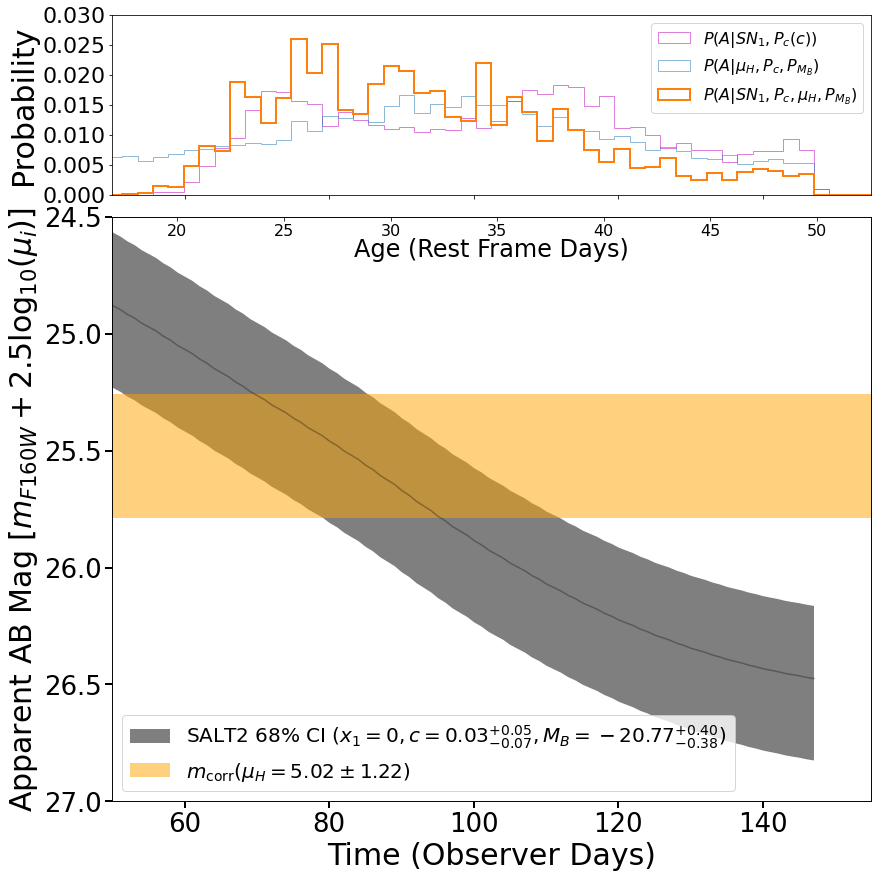

time  band psf_flux apcorr ...        mag                magerr         image 
---- ----- -------- ------ ... ------------------ -------------------- -------
 0.0 f105w   2.3471  1.192 ... 22.973671016392306 0.007401133313450642 image_2
 0.0 f160w   3.5715  1.262 ... 22.517873363848597   0.0137707433851323 image_2


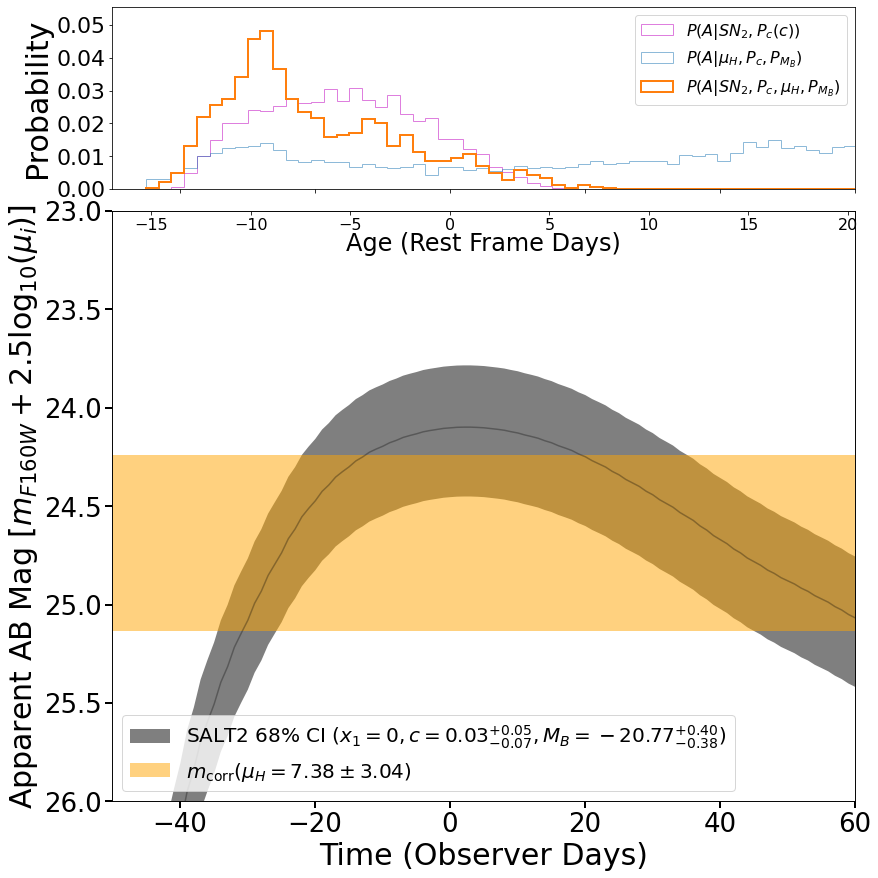

time  band psf_flux apcorr ...        mag                magerr        image 
---- ----- -------- ------ ... ------------------ ------------------- -------
 0.0 f105w   0.0877  1.192 ... 26.542501016584897  0.2042651083238313 image_3
 0.0 f160w   0.6113  1.262 ...  24.43436401052555 0.07690300997873385 image_3


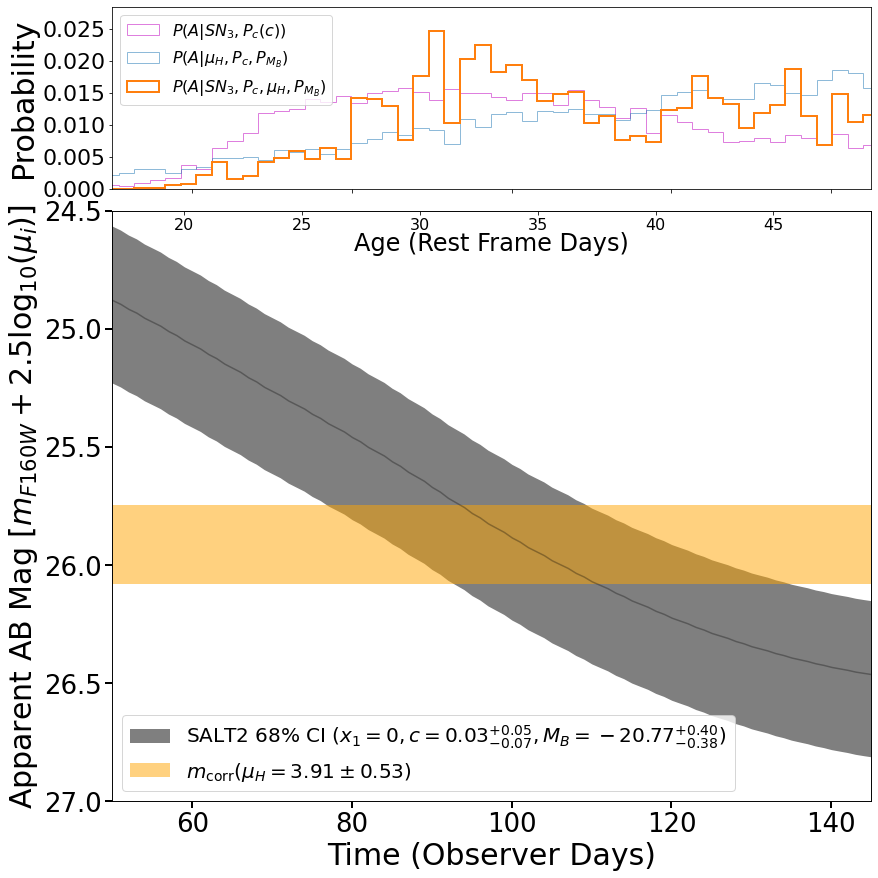

In [85]:
#make light curve fitting plots
plt.clf()
band='F160W'
dust = sncosmo.CCM89Dust()
model=sncosmo.Model('salt2-extended',effects=[dust],
                       effect_names=['mw'],
                       effect_frames=['obs'])
model.set(**{'z':1.9459,'mwebv':.014,'t0':0,'x1':0})

model.set_source_peakabsmag(-19.365,'bessellb','ab')


ylim_dict={2:(24.5,27),1:(23,26),0:(24.5,27)}
xlim_dict={2:(50,145),1:(-50,60),0:(50,155)}
# ylim_dict={2:(26.5,28.5),1:(24,26),0:(26.5,29)}
# xlim_dict={2:(50,145),1:(-50,60),0:(50,145)}
mod_result=pickle.load(open('lc_modelH_constraint_sntd.pkl','rb'))
bestMod_cfit=pickle.load(open('lc_modelH_color_constraint_sntd.pkl','rb'))
#cnest_noprior=pickle.load(open('colorcurve_constraint_noprior.pkl','rb'))
cnest_prior=pickle.load(open('colorcurve_constraint_sntd.pkl','rb'))
print(len(mod_result.weights),len(bestMod_cfit.weights),len(cnest_prior.weights))
for i in range(cnest_prior.samples.shape[0]):
    tempc=deepcopy(cnest_prior.samples[i,1])
    cnest_prior.samples[i,1]=-1*deepcopy(cnest_prior.samples[i,0])
    cnest_prior.samples[i,0]=deepcopy(tempc)
    cnest_prior.samples[i,2]=cnest_prior.samples[i,1]-cnest_prior.samples[i,2]
    cnest_prior.samples[i,3]=cnest_prior.samples[i,1]-cnest_prior.samples[i,3]
temp_mod=sncosmo.Model('salt2-extended')
temp_mod.set(z=1.9459)
for i in range(mod_result.samples.shape[0]):
    temp_mod.set(x0=mod_result.samples[i,0])
    mod_result.samples[i,0]=temp_mod.source_peakabsmag('bessellb','ab',cosmo=cosmology)
    tempc=deepcopy(mod_result.samples[i,2])
    mod_result.samples[i,2]=-1*deepcopy(mod_result.samples[i,1])
    mod_result.samples[i,1]=deepcopy(tempc)
    mod_result.samples[i,3]=mod_result.samples[i,2]-mod_result.samples[i,3]
    mod_result.samples[i,4]=mod_result.samples[i,2]-mod_result.samples[i,4]
#for i in range(bestMod_cfit.samples.shape[0]):
#    bestMod_cfit.samples[i,2]*=-1
#    bestMod_cfit.samples[i,3]=bestMod_cfit.samples[i,2]-bestMod_cfit.samples[i,3]
#    bestMod_cfit.samples[i,4]=bestMod_cfit.samples[i,2]-bestMod_cfit.samples[i,4]
best_model='H'
mod_result={best_model:mod_result}
quantile_dict={}
for q in [2.5,16,50,84,97.5]:
    M_B,c,t0, t1,t2 = [weighted_quantile(bestMod_cfit.samples[:,i], q/100, 
                                     sample_weight=bestMod_cfit.weights)\
                   for i in range(5)]
    quantile_dict['t0_%s'%str(q)]=t0
    quantile_dict['t1_%s'%str(q)]=t1
    quantile_dict['t2_%s'%str(q)]=t2
    quantile_dict['c_%s'%str(q)]=c
    quantile_dict['M_B_%s'%str(q)]=M_B
print(quantile_dict['t0_50'],
      quantile_dict['t1_50'],
      quantile_dict['t2_50'],
      quantile_dict['c_50'],
      quantile_dict['M_B_50'])
i=-1
#nbin_dict={0:150,1:300,2:350}
# nbin_dict={0:np.linspace(quantile_dict['t0_2.5'],quantile_dict['t0_97.5'],100),
#            1:np.linspace(quantile_dict['t1_2.5'],quantile_dict['t1_97.5'],100),
#            2:np.linspace(quantile_dict['t2_2.5'],quantile_dict['t2_97.5'],100)}
nbin_dict={0:np.linspace(xlim_dict[0][0]*.9,xlim_dict[0][1]*1.1,60),
           1:np.linspace(xlim_dict[1][0]*.9,xlim_dict[1][1]*1.1,60),
           2:np.linspace(xlim_dict[2][0]*.9,xlim_dict[2][1]*1.1,60)}

for im in [im0,im1,im2]:
    i+=1 
    
    time=np.arange(model.mintime(),model.maxtime(),2)
    
    plot_time=np.arange(time[0]-10,time[-1]+10,1)
    model.set(c=quantile_dict['c_50'])
    model.set_source_peakabsmag(quantile_dict['M_B_50'],'bessellb','ab')
    fig=plt.figure(figsize=(12,12))
    gs = gridspec.GridSpec(4,4)
    #fig,axes,gs=plot_util.grid_plot(4,4)
    ax_main=fig.add_subplot(gs[1:,:])
    ax_main=plot_util.plot('plot',plot_time,
                -2.5*np.log10(model.bandflux(band,plot_time,zp=zp,zpsys='ab'))+zp,ax=ax_main,x_lab='Time (Observer Days)',
                y_lab=r'Apparent AB Mag [$m_{'+band+'}+2.5\log_{10}(\mu_i)$]',ticklabelsize=ticksize,
                             fontsize=axis_fontsize,color='k',alpha=.3)
    plt.ylim(ylim_dict[i])
    plt.xlim(xlim_dict[i])
    model.set(c=quantile_dict['c_16'])
    model.set_source_peakabsmag(quantile_dict['M_B_16'],'bessellb','ab')
    min_cols=-2.5*np.log10(model.bandflux(band,plot_time,zp=zp,zpsys='ab'))+zp
    model.set(c=quantile_dict['c_84'])
    model.set_source_peakabsmag(quantile_dict['M_B_84'],'bessellb','ab')
    max_cols=-2.5*np.log10(model.bandflux(band,plot_time,zp=zp,zpsys='ab'))+zp
    ax_main.fill_between(plot_time,min_cols,max_cols,color='k',alpha=.5,linewidth=0,
            label='SALT2 68%'+' CI ($x_1=0,c=%.2f^{+%.2f}_{-%.2f},M_B=%.2f^{+%.2f}_{-%.2f}$)'%\
                         (quantile_dict['c_50'],quantile_dict['c_84']-quantile_dict['c_50'],
                                quantile_dict['c_50']-quantile_dict['c_16'],
                                quantile_dict['M_B_50'],
                                quantile_dict['M_B_84']-quantile_dict['M_B_50'],
                                quantile_dict['M_B_50']-quantile_dict['M_B_16']))
    
    '''
    #add 95% contours
    model.set(c=quantile_dict['c_97.5'])
    model.set_source_peakabsmag(quantile_dict['M_B_97.5'],'bessellb','ab')
    min_cols=-2.5*np.log10(model.bandflux(band,plot_time,zp=zp,zpsys='ab'))+zp
    model.set(c=quantile_dict['c_2.5'])
    model.set_source_peakabsmag(quantile_dict['M_B_2.5'],'bessellb','ab')
    max_cols=-2.5*np.log10(model.bandflux(band,plot_time,zp=zp,zpsys='ab'))+zp
    ax_main.fill_between(plot_time,min_cols,max_cols,color='k',alpha=.2,linewidth=0,
                         label='SALT2 95% CI')
    '''
    
    mod_cols={'C':'b','D':'r','H':'orange','F':'r'}
    

    temp_lens=models[models['MODEL']==best_model]
    print(im)
    mu=temp_lens['MU'][temp_lens['image']=='SN.'+str(im['id'][0]+1)]
    muerr_flux=temp_lens['ERR_MU'][temp_lens['image']=='SN.'+str(im['id'][0]+1)]
    muerr=1.0857*muerr_flux/mu
    b_ind=np.where(im['band']==band.lower())[0][0]
    magerr=1.0857*im['fluxerr'][b_ind]/im['flux'][b_ind]
    mag_err2=np.sqrt(magerr**2+muerr**2)
    all_mag=-2.5*np.log10(model.bandflux(band,plot_time,zp=zp,zpsys='ab'))+zp
    mod_mag=-2.5*np.log10(im['flux'][b_ind])+zp+2.5*np.log10(mu)
    ax_main.fill_between(plot_time,mod_mag+mag_err2,
                         mod_mag-mag_err2,linewidth=0,alpha=.5,
                         label=r'$m_{\rm{corr}}(\mu_'+best_model+'=%.2f\pm%.2f$)'%(mu,muerr_flux),
                         color=mod_cols[best_model])
    

    

    ax_main.legend(fontsize=legend_fontsize-4,loc='lower left')
        
    ax_top=fig.add_subplot(gs[0,:],sharex=ax_main)
    
    nbins=nbin_dict[i]

    #ax_top.hist(cnest_noprior.samples[:,i],weights=cnest_noprior.weights,bins=nbins,density=True,label='$P(A|SN_'+str(i+1)+')$',
    #           alpha=.5,histtype='step',color='c')
    ax_top.hist(cnest_prior.samples[:,i+1],weights=cnest_prior.weights,bins=nbins,
                density=True,label='$P(A|SN_'+str(i+1)+',P_c(c))$',alpha=.5,
                histtype='step',color='m')
    

    ax_top.hist(mod_result[best_model].samples[:,i+2],weights=mod_result[best_model].weights,bins=nbins,
            density=True,label='$P(A|\mu_'+best_model+',P_c,P_{M_B})$',
               alpha=.5,histtype='step')

    ax_top.hist(bestMod_cfit.samples[:,i+2],weights=bestMod_cfit.weights,bins=nbins,
            density=True,label='$P(A|SN_'+str(i+1)+',P_c,\mu_'+best_model+',P_{M_B})$',alpha=1,
                histtype='step',linewidth=2)
    for tick in ax_top.xaxis.get_major_ticks():
        tick.label.set_fontsize(ticksize-4)
    for tick in ax_top.yaxis.get_major_ticks():
        tick.label.set_fontsize(ticksize-4)
    loc = 'upper right' if i!=2 else 'upper left'
    ax_top.legend(fontsize=legend_fontsize-8,loc=loc)
    ax_top.set_ylabel('Probability',fontsize=axis_fontsize)
    ax_top.label_outer()
    ax_main_top=ax_main.twiny()
    ax_main_top.tick_params(direction='in',pad=-22)
    ax_main_top.tick_params(labelsize=16)
    ax_main_top.set_xlabel('Age (Rest Frame Days)',fontsize=axis_fontsize-6,labelpad=-40)
    ax_main_top.set_xlim((xlim_dict[i][0]/2.95,xlim_dict[i][1]/2.95))
    ylim=ax_top.get_ylim()
    scale=1.1 if i==1 else 1.1
    ax_top.set_ylim((ylim[0],ylim[1]*scale))
    plt.tight_layout(pad=0)
    ax_main.invert_yaxis()
    plt.savefig('lightcurve_image%i.pdf'%(i+1),format='pdf',overwrite=True)
    plt.show()